In [1]:
import pandas as pd
import numpy as np
# non official google trend API for python
# from pytrends.request import TrendReq
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import matplotlib.gridspec as gridspec
import seaborn as sns
# from matplotlib.dates import DateFormatter
import requests
import json
from scipy.stats import linregress

In [2]:
trend_usa   = pd.read_csv('../dataset/gooTrenNetf_USA.csv')
trend_spain = pd.read_csv('../dataset/gooTrenNetf_Spain.csv')

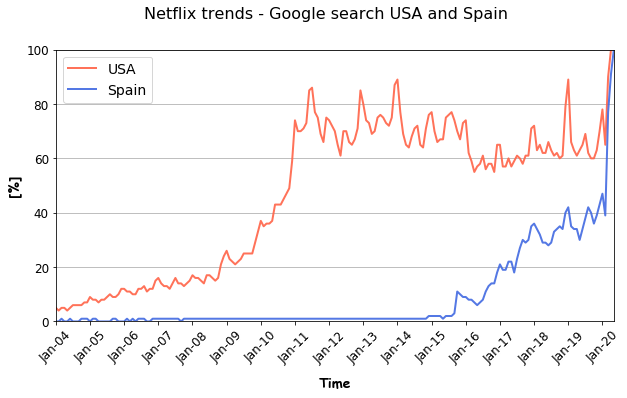

In [3]:
fig = plt.figure(figsize=[10,5])
fig.suptitle('Netflix trends - Google search USA and Spain', fontsize=16,y=1)

spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
axis = fig.add_subplot(spec[0,0],ylim=(0,100))

x = pd.to_datetime(trend_usa.index[1:]).strftime("%b-%y")
y = np.concatenate(trend_usa.values[1:].astype(int))
axis.plot(x, y, ls='-', color ='tomato' , lw=2, alpha=0.9, label='USA')

axis.tick_params(axis='y', labelsize=12)
label_prop = {'size':14,'weight':'bold','family':'fantasy'}
# axis.set_ylabel('Search relative interest [%]',fontdict=label_prop)
axis.set_ylabel('[%]',fontdict=label_prop)

xlabels = x[0::12]
axis.set_xticks(xlabels)
axis.tick_params(axis='x', labelsize=12, rotation=45)
axis.set_xlabel('Time',fontdict=label_prop)
axis.xaxis.set_label_coords(0.5, -0.2)

# data cleaning minor symbol
dataClean = trend_spain['Category: All categories'].str.replace('<','')
x = pd.to_datetime(trend_spain.index[1:]).strftime("%b-%y")
y = dataClean.values[1:].astype(int)
axis.plot(x, y, ls='-', color ='royalblue' , lw=2, alpha=0.9, label='Spain')

axis.grid(which='major', axis='y')
axis.legend(fontsize=14)
axis.set(xlim=[x[0], x[-1]])

event = ['2011-12','2012-12','2013-12','2014-12','2015-12','2016-12','2017-12','2018-12','2019-12']
usa_loc = trend_usa.loc[event].astype(int)
spain_loc = dataClean.loc[event].astype(int)
format_event = pd.to_datetime(event).strftime("%b-%y")
# axis.vlines(format_event, 0, usa_loc, ls='--', colors='r', lw=2, alpha=0.7)
# axis.vlines(format_event, 0, spain_loc, ls='--', colors='b', lw=2, alpha=0.7)
# fig.savefig('../images/usa_spain.png',dpi=800,bbox_inches='tight')

In [4]:
# Get netflix movie/tv show Title from dataset
movie_titles = pd.read_csv('../dataset/movie_titles.csv', encoding = 'ISO-8859-1',
                           header = None, names = ['Movie_Id', 'Year', 'Name'])
# Place movie_id as dataFrame index
movie_titles.set_index('Movie_Id', inplace = True)
movie_titles.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [5]:
# function for API callings to OMDb (input: title,year) (output: json)
def call_OMDb_API(title,year):
    OMDBkey = '69d73232'
    url = 'http://www.omdbapi.com/'
    if np.isnan(year):
        parameters = {'t':title,'plot':'full','apikey':OMDBkey}
    else:
        parameters = {'t':title,'y':year,'plot':'full','apikey':OMDBkey}
    response = requests.get(url,params=parameters)
    if response.status_code != 200:
        print(f"check status code: {response.status_code} for {title}, {year}")
    return response.json()

In [6]:
# extract data of interest from Json
def extract_interest(json_var):
    if json_var['Response'] == 'False':
        return np.NaN,np.NaN,np.NaN,np.NaN
    else:
        time = json_var['Runtime']
        types = json_var['Type']
        imdb_rate = json_var['imdbRating']
        imdb_n_votes = json_var['imdbVotes']
        return time,types,imdb_rate,imdb_n_votes

In [7]:
# 17770 titles in netflix training dataset (ambitious number of API calls)
start_in = 0
info_list = []
# turn flag on if you want to call API
flagRun = False
if flagRun:
    for i in movie_titles.index[start_in:]:
        title = movie_titles.Name[i]
        if np.isnan(movie_titles.Year[i]):
            year = np.nan
        else:
            year = int(movie_titles.Year[i])
        json_var = call_OMDb_API(title,year)
        info_list.append(extract_interest(json_var))

In [8]:
# read csv that is already concatenated (netflix movie titles with API info)
movies_join = pd.read_csv(f"../dataset/movies_join.csv")
# Place movie_id as dataFrame index
movies_join.set_index('Movie_Id', inplace = True)

In [9]:
# read netflix training sets
file_name = 'train_Netflix_3.txt'
def read_train_sets(file_name):
    df = pd.read_csv(f"../dataset/{file_name}",
                     header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
    return df
flagRead = False
if flagRead:
    training_3 = read_train_sets(file_name)

In [10]:
def get_agg_rates(df):
    # use nan to distinguish movie Id's (see Netflix prize dataset documentation)
    point_nan = pd.isnull(df.Rating)
    # recall still movie num is string (and training set mixes TV SHOWS AND MOVIES)
    movie_num = df.Cust_Id[point_nan]
    # Get the movie/tv show average across user ratings!
    mov_rat_mean = [df.Rating[movie_num.index[i]+1:movie_num.index[i+1]].mean() for i in range(len(movie_num)-1)]
    # append the last movie/tv show
    mov_rat_mean.append(df.Rating[movie_num.index[-1]+1:].mean())
    # Get the movie/tv show median across user ratings!
    mov_rat_med = [df.Rating[movie_num.index[i]+1:movie_num.index[i+1]].median() for i in range(len(movie_num)-1)]
    # append the last movie/tv show
    mov_rat_med.append(df.Rating[movie_num.index[-1]+1:].median())
    # Get the movie/tv show mode across user ratings!
    mov_rat_mod = [df.Rating[movie_num.index[i]+1:movie_num.index[i+1]].mode()[0] for i in range(len(movie_num)-1)]
    # append the last movie/tv show
    mov_rat_mod.append(df.Rating[movie_num.index[-1]+1:].mode()[0])
    # get movie/tv show num as integer after striping string
    movie_index = movie_num.reset_index().Cust_Id.apply(lambda x: int(x.strip(':')))
    return mov_rat_mean,mov_rat_med,mov_rat_mod,movie_index

In [11]:
# read csv that is already concatenated (netflix movie titles with API info and netflix ratings!)
movies_join_agg = pd.read_csv(f"../dataset/movies_join_agg.csv")
# Place movie_id as dataFrame index
movies_join_agg.set_index('Movie_Id', inplace = True)

In [12]:
movies_join_agg.head()

,Year,Name,time,type,rate,votes,mean,med,mod
Movie_Id,,,,,,,,,
1,2003.0,Dinosaur Planet,50 min,series,7.7,410,3.749543,4.0,4.0
2,2004.0,Isle of Man TT 2004 Review,NaN,NaN,NaN,NaN,3.558621,4.0,4.0
3,1997.0,Character,122 min,movie,7.7,"10,015",3.641153,4.0,4.0
4,1994.0,Paula Abdul's Get Up & Dance,NaN,NaN,NaN,NaN,2.739437,3.0,3.0
5,2004.0,The Rise and Fall of ECW,NaN,NaN,NaN,NaN,3.919298,4.0,5.0


In [13]:
# Get the correlation between two different rated sources netflix and omdb API
# all non null OMDb rates
idx = movies_join_agg.rate.notnull()
x = movies_join_agg[idx]['mean']
y = movies_join_agg[idx]['rate']

In [14]:
# calculate correlations!
# function get_covar with arrays X, Y as inputs
def get_covar(X,Y):
    return np.dot(X-X.mean(),Y-Y.mean())/(len(X)-1)
def get_corr(X,Y):
    return get_covar(X,Y)/(X.std()*Y.std())
# function lin_reg works with arrays X, Y as inputs
def lin_reg(X,Y):
    # build matrix A
    A = np.vstack((np.ones((len(X))),X)).T
    # solve the linear system
    alfa, beta = np.linalg.solve(np.matmul(A.T,A),np.matmul(A.T,Y))
    return alfa, beta

In [15]:
alfa,beta = lin_reg(x,y)
# round(get_corr(x,y),2)
# round(np.corrcoef(x,y)[0,1],2)
x_est = np.linspace(0,5,100)
y_est = alfa + x_est*beta
beta

1.7044464515826983

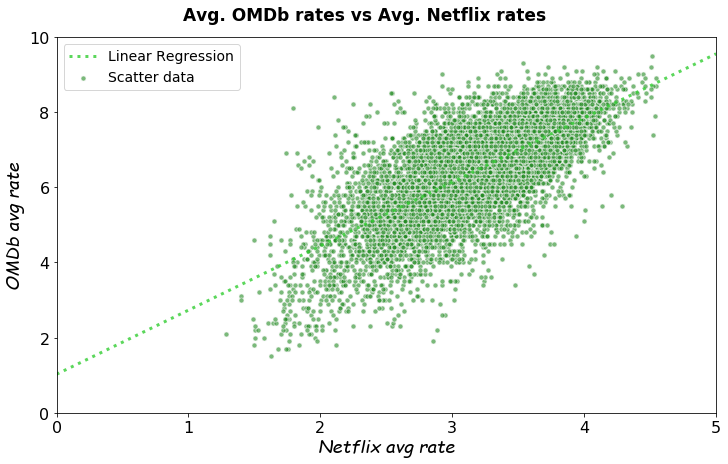

In [16]:
fig = plt.figure(figsize=[10,6],constrained_layout=True)
fig.suptitle('Avg. OMDb rates vs Avg. Netflix rates', size=17, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
label_prop = {'size':18,'family':'fantasy','style':'oblique'}
axis = fig.add_subplot(spec[0,0])
axis.scatter(x,y,s=25,alpha=0.6,marker='o',ec='whitesmoke',fc='forestgreen',label='Scatter data')
plt.sca(axis)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Netflix avg rate',fontdict=label_prop)
plt.ylabel('OMDb avg rate',fontdict=label_prop)
plt.xlim(0,5)
plt.ylim(0,10)

axis.plot(x_est, y_est, color='limegreen', label='Linear Regression', lw=3, ls=':',alpha=0.8)
axis.legend(fontsize=14)

# fig.savefig('../images/corr_rates.png',dpi=800,bbox_inches='tight')

Text(0, 0.5, 'Density')

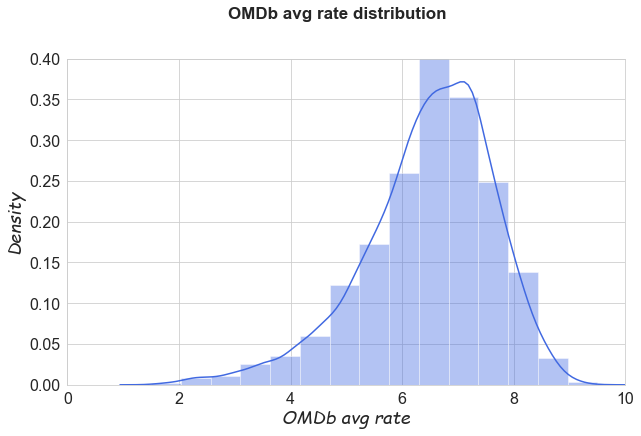

In [17]:
# your code here
sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,6)) # plt.figure(figsize=[7,5],constrained_layout=True)
fig.suptitle('OMDb avg rate distribution', size=17, weight='bold',y=1)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
axis = fig.add_subplot(spec[0,0])
sns.distplot(y,bins=15,color='royalblue',ax=axis)
# Tweak using Matplotlib
plt.sca(axis)
plt.ylim(0, 0.4)
plt.xlim(0, 10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
label_prop = {'size':18,'family':'fantasy','style':'oblique'}
plt.xlabel('OMDb avg rate',fontdict=label_prop)
plt.ylabel('Density',fontdict=label_prop)

# fig.savefig('../images/omdb_rates.png',dpi=800,bbox_inches='tight')

In [44]:
# It is time now to get data from IMDb web scraped (only movies in theory) !!!
imdb = pd.read_csv('../dataset/IMDb_movies.csv', usecols = ['title','year','genre','duration','country','avg_vote','votes'])

In [47]:
imdb.tail()

,title,year,genre,duration,country,avg_vote,votes
81268,Jessie,2019,"Horror, Thriller",106,India,7.2,219
81269,Ottam,2019,Drama,120,India,7.8,510
81270,Pengalila,2019,Drama,111,India,8.4,604
81271,Padmavyuhathile Abhimanyu,2019,Drama,130,India,8.4,369
81272,Sokagin Çocuklari,2019,"Drama, Family",98,Turkey,7.2,190


In [51]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81273 entries, 0 to 81272
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     81273 non-null  object 
 1   year      81273 non-null  int64  
 2   genre     81273 non-null  object 
 3   duration  81273 non-null  int64  
 4   country   81234 non-null  object 
 5   avg_vote  81273 non-null  float64
 6   votes     81273 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 4.3+ MB


In [124]:
imdb[imdb.duration == imdb.duration.max()]

,title,year,genre,duration,country,avg_vote,votes
61516,The Clock,2010,Drama,3360,UK,8.8,230


In [76]:
# filter USA (27490 movies) and see years
idx = imdb.country == 'USA'
# year batches (from 1912-2019) / split in 5
# 294 hasta 1925
idx_25 = imdb[idx].year <= 1925
tag_25 = pd.DataFrame(index=idx_25.index)
tag_25['Tag'] = ''
tag_25.loc[idx_25] = '<1925'
imdb_tag = imdb.join(tag_25)

In [81]:
# 4765 entre 1925 y 1950
idx_50 = (imdb[idx].year > 1925) & (imdb[idx].year <= 1950)
tag_50 = pd.DataFrame(index=idx_50.index)
tag_50['Tag'] = ''
tag_50.loc[idx_50] = '1925-1950'
tag_50.head()
imdb_tag.loc[tag_50.index[idx_50], ['Tag']] = tag_50.loc[tag_50.index[idx_50], ['Tag']]

In [86]:
# 4234 entre 1950 y 1975
idx_75 = (imdb[idx].year > 1950) & (imdb[idx].year <= 1975)
tag_75 = pd.DataFrame(index=idx_75.index)
tag_75['Tag'] = ''
tag_75.loc[idx_75] = '1950-1975'
tag_75.head()
imdb_tag.loc[tag_75.index[idx_75], ['Tag']] = tag_75.loc[tag_75.index[idx_75], ['Tag']]

In [92]:
# 6530 entre 1975 y 2000
idx_00 = (imdb[idx].year > 1975) & (imdb[idx].year <= 2000)
tag_00 = pd.DataFrame(index=idx_00.index)
tag_00['Tag'] = ''
tag_00.loc[idx_00] = '1975-2000'
tag_00.head()
imdb_tag.loc[tag_00.index[idx_00], ['Tag']] = tag_00.loc[tag_00.index[idx_00], ['Tag']]

In [95]:
# 11667 > 2000
idx_new = (imdb[idx].year > 2000)
tag_new = pd.DataFrame(index=idx_new.index)
tag_new['Tag'] = ''
tag_new.loc[idx_new] = '>2000'
tag_new.head()
idx_new.sum()
imdb_tag.loc[tag_new.index[idx_new], ['Tag']] = tag_new.loc[tag_new.index[idx_new], ['Tag']]

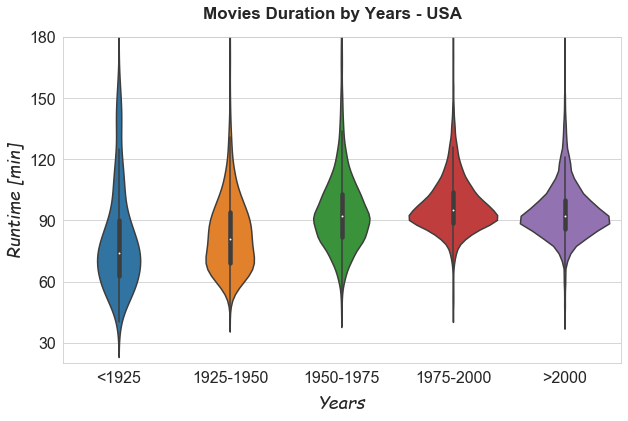

In [121]:
# violin plots movie durations through years

fig = plt.figure(figsize=(10,6)) # plt.figure(figsize=[7,5],constrained_layout=True)
fig.suptitle('Movies Duration by Years - USA', size=17, weight='bold',y=0.95)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
axis = fig.add_subplot(spec[0,0])
sns.violinplot(x=imdb_tag[idx].Tag,y=imdb[idx].duration,ax=axis,order=['<1925','1925-1950','1950-1975','1975-2000','>2000'])

# Tweak using Matplotlib
plt.sca(axis)
plt.ylim(20,180)
plt.xticks(fontsize=16)
ylabels = np.arange(30,181,30)
plt.yticks(ylabels,fontsize=16)
label_prop = {'size':18,'family':'fantasy','style':'oblique'}
plt.xlabel('Years',fontdict=label_prop)
axis.xaxis.set_label_coords(0.5, -0.1)
plt.ylabel('Runtime [min]',fontdict=label_prop)

fig.savefig('../images/usa_trends.png',dpi=800,bbox_inches='tight')

In [97]:
# 70:90
# 470:490
# 8470:8490
# 24700:24900
# imdb_tag[64700:64900]
# 11667+6530+4234+4765+294

In [43]:
# imdb other datasets
# 'wordsInTitle','imdbRating','ratingCount','duration','year'

In [20]:
# # get other out!
# x_h = 3.61875
# y_l = 3.7213
# # OK try to get the position !
# idxh1 = x > x_h - 0.001
# idxh2 = x < x_h + 0.001
# idyl1 = y > y_l - 0.05
# idyl2 = y < y_l + 0.05
# logic1 = idxh1 & idxh2
# logic2 = idyl1 & idyl2
# movies_join_agg.index[idx][logic1 & logic2]
# movies_join_agg.loc[1416]

In [21]:
# # get outlier!
# x_l = 1.79154
# y_h = 8.13
# # OK try to get the position !
# idxl1 = x > x_l - 0.01
# idxl2 = x < x_l + 0.01
# idyh1 = y > y_h - 0.0301
# idyh2 = y < y_h + 0.0301
# logic1 = idxl1 & idxl2
# logic2 = idyh1 & idyh2
# (logic1 & logic2).sum()
# movies_join_agg.index[idx][logic1 & logic2]
# movies_join_agg.loc[14957]

In [22]:
# # movie_int.head()
# dict_agg = {'Movie_Id':movie_index.values,'mean':mov_rat_mean,'med':mov_rat_med,'mod':mov_rat_mod}
# agg_df = pd.DataFrame(dict_agg).set_index('Movie_Id')
# agg_df.head()
# movies_join1 = movies_join.join(agg_df)
# movies_join1.head()

In [23]:
# dict_agg = {'Movie_Id':movie_index.values,'mean':mov_rat_mean,'med':mov_rat_med,'mod':mov_rat_mod}
# agg_df = pd.DataFrame(dict_agg).set_index('Movie_Id')
# agg_df.tail()
# idx0 = movie_index.values[0]
# idx1 = movie_index.values[-1]
# movies_join1.loc[idx0:idx1, ['mean','med','mod']] = agg_df.loc[idx0:idx1, ['mean','med','mod']]
# movies_join1.tail()

In [24]:
# movies_join1.to_csv(f"../dataset/movies_join_agg.csv")

In [25]:
# mov_rat_mean,mov_rat_med,mov_rat_mod,movie_index = get_agg_rates(training_3)

In [26]:
# # read netflix training set 1
# training_1 = pd.read_csv('../dataset/train_Netflix_1.txt',
#                          header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

In [27]:
# # use nan to distinguish movie Id's (see Netflix prize dataset documentation)
# point_nan = pd.isnull(training_1.Rating)
# # recall still movie num is string (and training set mixes TV SHOWS AND MOVIES)
# movie_num = training_1.Cust_Id[point_nan]

In [28]:
# # Get the movie/tv show average across user ratings!
# mov_rat_mean = [training_1.Rating[movie_num.index[i]+1:movie_num.index[i+1]].mean() for i in range(len(movie_num)-1)]
# # append the last movie/tv show
# mov_rat_mean.append(training_1.Rating[movie_num.index[-1]+1:].mean())

In [29]:
# # get movie/tv show num as integer after striping string
# movie_int = movie_num.reset_index().Cust_Id.apply(lambda x: int(x.strip(':')))

In [30]:
# # function for csv reading 
# def read_from_csv(idx0,idx1):
#     file_name = f"api_out_{idx0}_{idx1}"
#     info_df = pd.read_csv(f"../dataset/{file_name}.csv",skiprows = 1,
#                           names = ['Movie_Id', 'time','type','rate','votes'])
#     # Place movie_id as dataFrame index
#     info_df.set_index('Movie_Id', inplace = True)
#     return info_df
# info_df1 = read_from_csv(1,2555)
# movies_join = movie_titles.join(info_df1)
# idx0 = 2556
# idx1 = 4387
# info_df2 = read_from_csv(idx0,idx1)
# movies_join.loc[idx0:idx1, ['time','type','rate','votes']] = info_df2.loc[idx0:idx1, ['time','type','rate','votes']]
# idx0 = 4388
# idx1 = 7724
# info_df3 = read_from_csv(idx0,idx1)
# movies_join.loc[idx0:idx1, ['time','type','rate','votes']] = info_df3.loc[idx0:idx1, ['time','type','rate','votes']]
# idx0 = 7725
# idx1 = 11382
# info_df4 = read_from_csv(idx0,idx1)
# movies_join.loc[idx0:idx1, ['time','type','rate','votes']] = info_df4.loc[idx0:idx1, ['time','type','rate','votes']]
# idx0 = 11383
# idx1 = 11918
# info_df5 = read_from_csv(idx0,idx1)
# movies_join.loc[idx0:idx1, ['time','type','rate','votes']] = info_df5.loc[idx0:idx1, ['time','type','rate','votes']]
# idx0 = 11919
# idx1 = 17770
# info_df6 = read_from_csv(idx0,idx1)
# movies_join.loc[idx0:idx1, ['time','type','rate','votes']] = info_df6.loc[idx0:idx1, ['time','type','rate','votes']]

# movies_join.to_csv(f"../dataset/movies_join.csv")

In [31]:
# movies_join.loc[20,['time','type','rate','votes']]

In [32]:
# # retrieve data taken from API calls
# idx0 = 1
# idx1 = 2555
# file_name = f"api_out_{idx0}_{idx1}"
# info_df = pd.read_csv(f"../dataset/{file_name}.csv",skiprows = 1,
#                       names = ['Movie_Id', 'time','type','rate','votes'])
# # Place movie_id as dataFrame index
# info_df.set_index('Movie_Id', inplace = True)
# info_df.head()

In [33]:
# # save temp data from API calls
# info_df = pd.DataFrame(info_list)
# info_df.index = list(range(start_in+1,len(info_df)+start_in+1))
# info_df.columns = ['time','type','rate','votes']
# info_df.tail()
# file_name = f"api_out_{info_df.index[0]}_{info_df.index[-1]}"
# # file_name
# info_df.to_csv(f"../dataset/{file_name}.csv")

In [34]:
# s1 = pd.Series(['Mouse', 'doG', 'house and parrot', '23', np.NaN])
# s1.str.contains('Og', case=False, regex=True)

In [35]:
# doesn't look like I need to append this data really...
# Get title names and year from the rated movies/tv shows
# rated_names = [(movie_titles.Name[i],movie_titles.Year[i]) for i in movie_int]

In [36]:
# # Now I want to filter only movies and get their duration
# # I don't have that information from Netflix training dataset
# # I'll try to get that info from OMDb API (1$ paid for 100,000 calls per month!)

# # http://www.omdbapi.com/?i=tt3896198&apikey=69d73232

# OMDBkey = '69d73232'
# title = movie_titles.Name[1]
# year = int(movie_titles.Year[1])
# url = 'http://www.omdbapi.com/'
# # url = f"http://www.omdbapi.com/?apikey=[{OMDBkey}]"
# # http://www.omdbapi.com/? t=Dinosaur+Planet & y=2003 & plot=full
# parameters = {'t':title,'y':year,'plot':'full','apikey':OMDBkey}
# response = requests.get(url,params=parameters)
# json_var = response.json()

In [37]:
# training_1.info()
# training_1.head()

In [38]:
# movie_num.tail()
# movie_num.index

In [39]:
# training_1.Rating[1:548].tail()

In [40]:
# training_1.Rating[1:548].median()
# training_1.Rating[549:694].mean()
# training_1.Rating[695:2707].mean()

In [41]:
# movie_num.tail()
# movie_num.index[-1]
# training_1.Rating[24057835:].mean()
# training_1.Rating[movie_num.index[-1]+1:].mean()

In [42]:
# mov_rat_mean[2]